

Baseline model used as check point reference

*   This is the baseline CNN (DenseNet-121) without any fairness aware intervention
*   All datasets were treated the same before splitting ( in the previous notebooks (3) )
* EDA to find the source of bias in the dataset
* data preprocesing before training
* general performance evaluation /fairness evaluation
*subgroup analysis
*explainability tools (Grad-CAM)



In [ ]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''Pandas and NumPy used for handling data and preprocessing,
PyTorch served as the primary DL framework for model development
and training,Scikit-learn was used for performance evaluation, subgroup analysis,
and statistical comparisons. Matplotlib PROVIDE result visualization,
and OpenCV and PIL were used for image loading, resizing, and normalization'''
# import needed library
import os #to navigate directories
import cv2 # to use image operation
import torch #for tensor operations and GPU
import torch.nn as nn # to define neural network layers
import torch.optim as optim #update model parameters during training
import pandas as pd # to manage tabular
import numpy as np # numerical operations
import matplotlib.pyplot as plt # to deal with visualize data

from torch.utils.data import Dataset, DataLoader #create a custom dataset class
from torchvision import models, transforms#load pretrained CNN and data augmentation pipelines.
from PIL import Image #load and convert images
from tqdm import tqdm #display progress bars during training

from sklearn.metrics import roc_auc_score, accuracy_score #evaluate the model


**Exploratory Data Analysis (EDA)**

In [ ]:
#loads predefined training, validation, and test splits from CSV files
train_df = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/training_split.csv")
val_df   = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/validation_split.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/test_samples.csv")

In [ ]:
# I will check the shape and the column name
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
train_df.columns

(12800, 32)
(3200, 32)
(4000, 32)


Index(['study_id', 'series_id', 'image_id', 'laterality', 'view_position',
       'height', 'width', 'breast_birads', 'breast_density', 'split',
       'Series Instance UID', 'Patient's Age', 'View Position',
       'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns',
       'Imager Pixel Spacing', 'Pixel Spacing', 'Pixel Padding Value',
       'Pixel Padding Range Limit', 'Window Center', 'Window Width',
       'Rescale Intercept', 'Rescale Slope', 'Rescale Type',
       'Window Center & Width Explanation', 'Manufacturer',
       'Manufacturer's Model Name', 'Age Group', 'image_path_in_zip',
       'preprocessed_path'],
      dtype='object')

Training dataset

Path: /content/drive/MyDrive/VinDr_mammo.png/preprocessed_training_images/0d8963e97b74a1e9b2b23c2e07bf94d8.png
Size: (224, 224), Mode: L


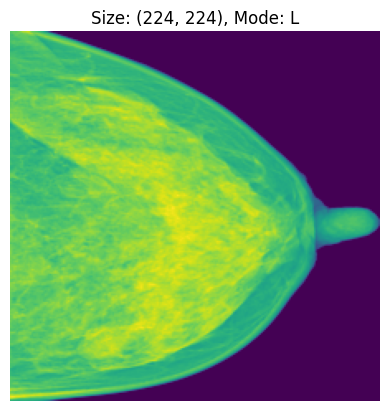

Path: /content/drive/MyDrive/VinDr_mammo.png/preprocessed_training_images/2795c8febc2b642abbb9771b9f1591cd.png
Size: (224, 224), Mode: L


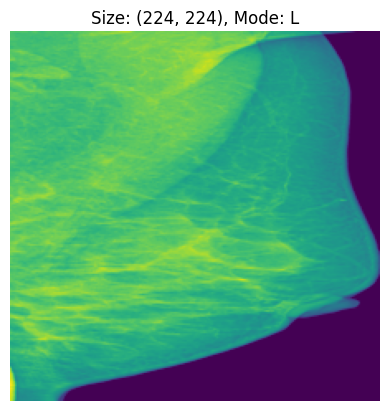

Path: /content/drive/MyDrive/VinDr_mammo.png/preprocessed_training_images/11f9a54dcd0e8f572ced49e663a1573e.png
Size: (224, 224), Mode: L


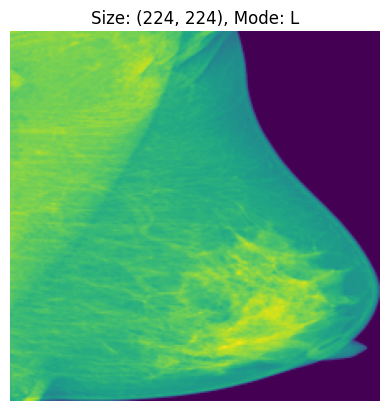

Path: /content/drive/MyDrive/VinDr_mammo.png/preprocessed_training_images/526667a8cdf9eefbd9e3e1c2999ed5e6.png
Size: (224, 224), Mode: L


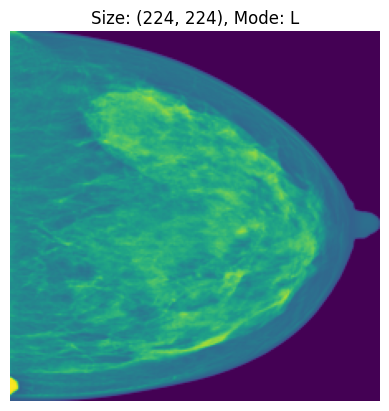

Path: /content/drive/MyDrive/VinDr_mammo.png/preprocessed_training_images/b8db51bebab3c8b31f3746f5d787945a.png
Size: (224, 224), Mode: L


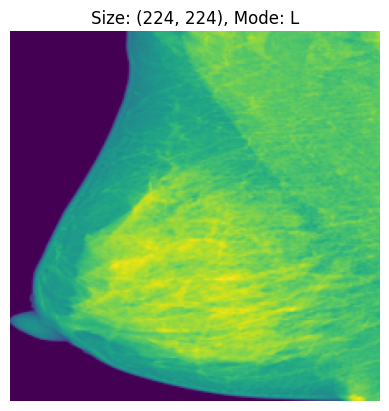

In [ ]:
'''check few preprocessed mammography images from the training set, prints their dimensions and pixel format,
and displays them for visual inspection to verify correct preprocessing and accessibility of the dataset'''


for path in train_df['preprocessed_path'].head():
    img = Image.open(path)
    print(f"Path: {path}")
    print(f"Size: {img.size}, Mode: {img.mode}")

    # Show image
    plt.imshow(img)
    plt.title(f"Size: {img.size}, Mode: {img.mode}")
    plt.axis("off")
    plt.show()


In [ ]:
# recheck image (width,hight ) and image mode
for path in train_df['preprocessed_path'].head():
    img = Image.open(path)
    print(path, img.size, img.mode)

/content/drive/MyDrive/VinDr_mammo.png/preprocessed_training_images/0d8963e97b74a1e9b2b23c2e07bf94d8.png (224, 224) L
/content/drive/MyDrive/VinDr_mammo.png/preprocessed_training_images/2795c8febc2b642abbb9771b9f1591cd.png (224, 224) L
/content/drive/MyDrive/VinDr_mammo.png/preprocessed_training_images/11f9a54dcd0e8f572ced49e663a1573e.png (224, 224) L
/content/drive/MyDrive/VinDr_mammo.png/preprocessed_training_images/526667a8cdf9eefbd9e3e1c2999ed5e6.png (224, 224) L
/content/drive/MyDrive/VinDr_mammo.png/preprocessed_training_images/b8db51bebab3c8b31f3746f5d787945a.png (224, 224) L



=== breast_density ===
breast_density
DENSITY A      59
DENSITY B    1210
DENSITY C    9802
DENSITY D    1729
Name: count, dtype: int64

=== breast_birads ===
breast_birads
BI-RADS 1    8589
BI-RADS 2    2997
BI-RADS 3     586
BI-RADS 4     483
BI-RADS 5     145
Name: count, dtype: int64

=== Age Group ===
Age Group
20-29     474
30-39    2397
40-49    6441
50-59    2592
60-69     674
70-79      95
80-89      20
<20       107
Name: count, dtype: int64


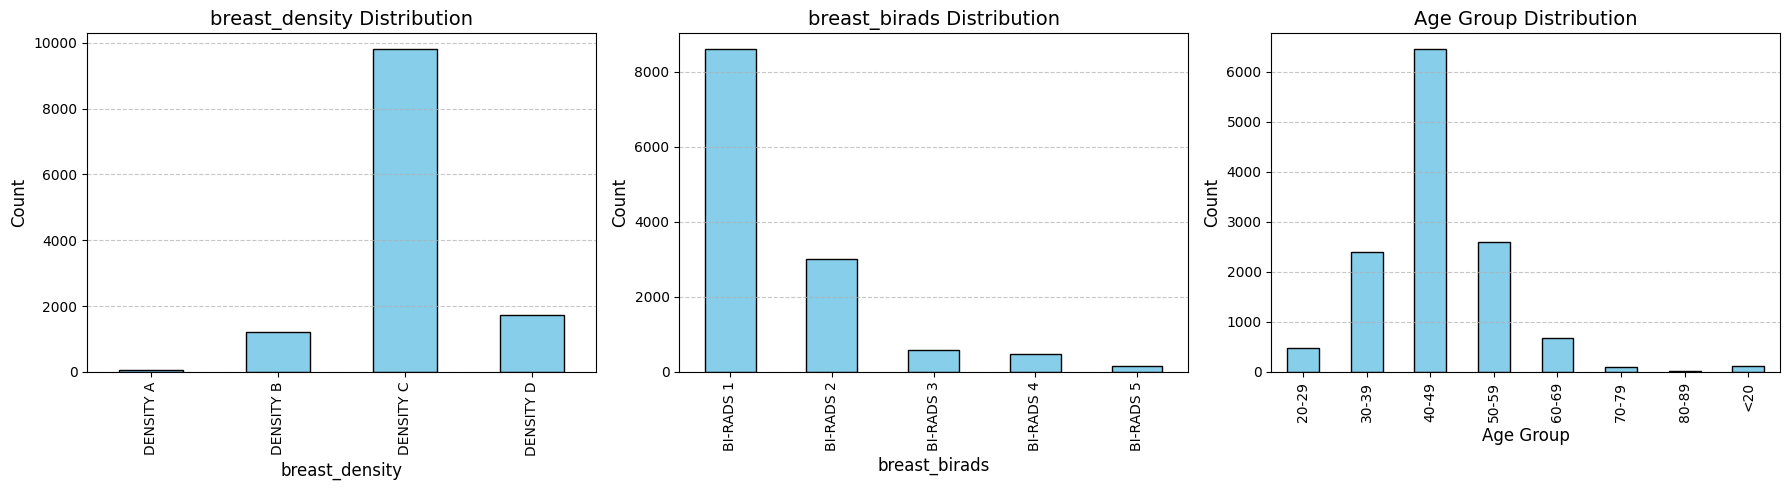

In [ ]:
# this to check the DISTRIBUTION of the needed feature and target in train dataset

# name of columns to visualize
cols_to_plot = ['breast_density', 'breast_birads', 'Age Group']

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes, cols_to_plot):
    # Count values including NaN as a category
    counts = train_df[col].fillna('NaN').value_counts().sort_index()

    # to show numeric value
    print(f"\n=== {col} ===")
    print(counts)

    # Plot bar chart
    counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
    ax.set_title(f'{col} Distribution', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
print(train_df['breast_birads'].unique())

['BI-RADS 1' 'BI-RADS 3' 'BI-RADS 2' 'BI-RADS 4' 'BI-RADS 5']


In [ ]:
#manage dataset class for vindr mammography image
'''This class explain how to load and prepare each sample from the dataset.
and will do the following :
1. The image (preprocessed and converted to RGB)
2. The binary label (BI-RADS 1–2 will converted to 0 (low risk), BI-RADS 3–5 to 1(need follow up or cancer))
3. Additional metadata: age group and breast density'''
def birads_to_binary(birads_str):
    num = int(birads_str.split()[-1])  # 'BI-RADS 1' -> 1
    return 0 if num in [1, 2] else 1

# Apply to the column
train_df['label'] = train_df['breast_birads'].apply(birads_to_binary)
val_df['label'] = val_df['breast_birads'].apply(birads_to_binary)
test_df['label'] = test_df['breast_birads'].apply(birads_to_binary)

# Quick check
print(train_df[['breast_birads', 'label']].head(10))
print(train_df['label'].value_counts())


  breast_birads  label
0     BI-RADS 1      0
1     BI-RADS 1      0
2     BI-RADS 1      0
3     BI-RADS 1      0
4     BI-RADS 1      0
5     BI-RADS 3      1
6     BI-RADS 1      0
7     BI-RADS 1      0
8     BI-RADS 3      1
9     BI-RADS 1      0
label
0    11586
1     1214
Name: count, dtype: int64


In [ ]:
'''This custom PyTorch dataset class loads preprocessed images and  their
 diagnostic labels and demographic features,
 enabling both predictive modeling and fairness-aware evaluation'''

class VinDrDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        image = Image.open(row["preprocessed_path"]).convert("RGB")

        # Use precomputed label
        label = row['label']

        age_group = row["Age Group"]
        density = row["breast_density"]

        if self.transform:
            image = self.transform(image)

        return image, label, age_group, density


In [ ]:
#Transforms and  DataLoaders

'''in ransform the code will do the following:
  - Resize all images to 224x224
 - RandomHorizontalFlip for data augmentation to improve generalization.
 - ToTensor converts images from PIL format (0–255) to PyTorch tensors (0–1).
 - Normalize uses ImageNet mean and standard deviation to standardize input for pretrained models.'''
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

eval_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

''' for dataloader, the following will happen - Wraps the custom VinDrDataset for batch processing.
- train_loader shuffles data for training.
- val_loader and test_loader do not shuffle to preserve sample order for evaluation.
- Batch size is set to 32 for efficient GPU/CPU usage.'''
train_loader = DataLoader(VinDrDataset(train_df, train_tf), batch_size=32, shuffle=True)
val_loader   = DataLoader(VinDrDataset(val_df, eval_tf), batch_size=32, shuffle=False)
test_loader  = DataLoader(VinDrDataset(test_df, eval_tf), batch_size=32, shuffle=False)


In [ ]:
'''model: Use DenseNet-121 pretrained on ImageNet, replace the classifier for 2 classes (low vs high risk).
Move the model to GPU if available. Use CrossEntropyLoss as the loss function and Adam optimizer for training.'''


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
'''Early Stopping and Checkpoints specifications: stops training if no improvement after 6 epochs.
and to save the best and most recent model states so training can be resumed or best model reused.'''
CKPT_PATH = "/content/drive/MyDrive/IT_artefact/finalBaseline_checkpoints/"
os.makedirs(CKPT_PATH, exist_ok=True)

BEST_PATH = f"{CKPT_PATH}/baseline_best.pth"
LAST_PATH = f"{CKPT_PATH}/baseline_last.pth"

class EarlyStopping:
    def __init__(self, patience=6):
        self.patience = patience
        self.counter = 0
        self.best = None
        self.stop = False

    def step(self, value):
        if self.best is None or value > self.best:
            self.best = value
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
            return False

def save_ckpt(path, epoch, best_auc):
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "best_auc": best_auc
    }, path)

def load_ckpt(path):
    ckpt = torch.load(path)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    return ckpt["epoch"], ckpt["best_auc"]

In [ ]:
''' train model and validation function for each epoch:train_epoch runs one pass over the training data,
updates model weights, and returns loss + accuracy.
# validate runs one pass over validation data without updating weights and returns ROC AUC score.'''

def train_epoch(loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y, _, _ in tqdm(loader, desc="Training"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss/len(loader), correct/total

def validate(loader):
    model.eval()
    y_true, y_prob = [], []

    with torch.no_grad():
        for x, y, _, _ in loader:
            x = x.to(device)
            prob = torch.softmax(model(x),1)[:,1]
            y_true.extend(y.numpy())
            y_prob.extend(prob.cpu().numpy())

    return roc_auc_score(y_true, y_prob)


In [ ]:
'''Training Loop:  Train the model for multiple epochs, evaluate validation ROC AUC, save checkpoints,
and use early stopping to stop training if performance stops improving.'''
epochs = 20
early = EarlyStopping()
start_epoch, best_auc = 0, 0.0

if os.path.exists(LAST_PATH):  #Resume training if a previous checkpoint exists, and start from next epoch
    print("Resuming training...")
    start_epoch, best_auc = load_ckpt(LAST_PATH)
    start_epoch += 1

for epoch in range(start_epoch, epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    loss, acc = train_epoch(train_loader)
    val_auc = validate(val_loader)

    print(f"Loss: {loss:.4f} | Acc: {acc:.4f} | Val AUC: {val_auc:.4f}")

    save_ckpt(LAST_PATH, epoch, best_auc)

    if early.step(val_auc):
        best_auc = val_auc
        save_ckpt(BEST_PATH, epoch, best_auc)
        print(" Best model was saved")

    if early.stop:
        print("Early stopp")
        break



Epoch 1/20


Training: 100%|██████████| 400/400 [2:01:10<00:00, 18.18s/it]


Loss: 0.3108 | Acc: 0.9022 | Val AUC: 0.7349
 Best model was saved

Epoch 2/20


Training: 100%|██████████| 400/400 [01:18<00:00,  5.06it/s]


Loss: 0.2711 | Acc: 0.9133 | Val AUC: 0.7134

Epoch 3/20


Training: 100%|██████████| 400/400 [01:20<00:00,  4.98it/s]


Loss: 0.2470 | Acc: 0.9188 | Val AUC: 0.6961

Epoch 4/20


Training: 100%|██████████| 400/400 [01:20<00:00,  4.99it/s]


Loss: 0.2236 | Acc: 0.9241 | Val AUC: 0.7292

Epoch 5/20


Training: 100%|██████████| 400/400 [01:19<00:00,  5.00it/s]


Loss: 0.1958 | Acc: 0.9334 | Val AUC: 0.7144

Epoch 6/20


Training: 100%|██████████| 400/400 [01:19<00:00,  5.02it/s]


Loss: 0.1674 | Acc: 0.9414 | Val AUC: 0.7497
 Best model was saved

Epoch 7/20


Training: 100%|██████████| 400/400 [01:22<00:00,  4.87it/s]


Loss: 0.1331 | Acc: 0.9528 | Val AUC: 0.6965

Epoch 8/20


Training: 100%|██████████| 400/400 [01:19<00:00,  5.00it/s]


Loss: 0.1068 | Acc: 0.9644 | Val AUC: 0.7144

Epoch 9/20


Training: 100%|██████████| 400/400 [01:19<00:00,  5.02it/s]


Loss: 0.0809 | Acc: 0.9712 | Val AUC: 0.7041

Epoch 10/20


Training: 100%|██████████| 400/400 [01:19<00:00,  5.02it/s]


Loss: 0.0673 | Acc: 0.9771 | Val AUC: 0.7348

Epoch 11/20


Training: 100%|██████████| 400/400 [01:19<00:00,  5.00it/s]


Loss: 0.0519 | Acc: 0.9826 | Val AUC: 0.7264

Epoch 12/20


Training: 100%|██████████| 400/400 [01:19<00:00,  5.00it/s]


Loss: 0.0420 | Acc: 0.9853 | Val AUC: 0.7033
Early stopp


In [ ]:
#Load the checkpoint file that saved the model with the best validation performance
ckpt = torch.load(BEST_PATH, weights_only=False)  # allow full checkpoint load
model.load_state_dict(ckpt["model"])
model.eval()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#Collect Test Predictions: Run the trained model on the test set, store true labels, predicted probabilities, and metadata in a DataFrame for evaluation.
def collect_predictions(loader):
    rows = []
    with torch.no_grad():
        for x, y, age, dens in loader:
            x = x.to(device)
            probs = torch.softmax(model(x),1)[:,1]
            for i in range(len(y)):
                rows.append({
                    "y_true": int(y[i]),
                    "y_prob": float(probs[i].cpu()),
                    "age_group": age[i],
                    "breast_density": dens[i]
                })
    return pd.DataFrame(rows)

pred_df = collect_predictions(test_loader)


**General performance of the baseline model**


In [ ]:
from sklearn.metrics import confusion_matrix

# Set a threshold for classifying probabilities as 1
threshold = 0.5
y_pred = (pred_df['y_prob'] >= threshold).astype(int)
y_true = pred_df['y_true']

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Sensitivity (Recall for positive class)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0

# Specificity (Recall for negative class)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


Sensitivity: 0.2396
Specificity: 0.9704


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# AUC (using predicted probabilities)
auc = roc_auc_score(y_true, pred_df['y_prob'])

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")


Accuracy: 0.9002
AUC: 0.7204


**Subgroup evaluation and fairness evaluation**

In [ ]:
''' to Compute subgroup performance (AUC, Accuracy) and fairness metrics (Demographic Parity, Equal Opportunity)
 and to evaluate model performance and fairness across age groups or breast density subgroups.'''

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

#subgroup performance

def subgroup_performance_full(df, col):
    """
    Compute subgroup metrics:
    - AUC
    - Accuracy
    - Sensitivity (Recall for positive class)
    - Specificity (Recall for negative class)
    - Counts of classes
    """
    rows = []
    for g in df[col].unique():
        sub = df[df[col] == g]
        if len(sub) < 10:  # skip very small groups
            continue

        y_true = sub.y_true.values
        y_pred = (sub.y_prob >= 0.5).astype(int)

        if sub.y_true.nunique() < 2:
            auc = np.nan
        else:
            auc = roc_auc_score(y_true, sub.y_prob)

        acc = accuracy_score(y_true, y_pred)

        # Sensitivity & Specificity
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel() if len(np.unique(y_true))==2 else (np.nan, np.nan, np.nan, np.nan)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

        rows.append({
            col: g,
            "AUC": auc,
            "Accuracy": acc,
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "N": len(sub),
            "Class_0": (y_true == 0).sum(),
            "Class_1": (y_true == 1).sum()
        })

    return pd.DataFrame(rows)

#fairness metrics

def demographic_parity(df, col):
    df = df.copy()
    df["y_pred"] = (df.y_prob>=0.5).astype(int)
    rates = df.groupby(col)["y_pred"].mean()
    return rates.max() - rates.min()

def equal_opportunity(df, col):
    df = df[df.y_true==1].copy()
    df["y_pred"] = (df.y_prob>=0.5).astype(int)
    tpr = df.groupby(col)["y_pred"].mean()
    return tpr.max() - tpr.min()

def disparate_impact_ratio(df, col):
    df = df.copy()
    df["y_pred"] = (df.y_prob>=0.5).astype(int)
    rates = df.groupby(col)["y_pred"].mean()
    if len(rates) < 2:
        return np.nan
    return rates.min() / rates.max()

# run for predect
# Subgroup performance
age_perf = subgroup_performance_full(pred_df, "age_group")
density_perf = subgroup_performance_full(pred_df, "breast_density")

print("\n=== Subgroup performance: Age groups ===")
print(age_perf)

print("\n=== Subgroup performance: Breast density ===")
print(density_perf)

# Fairness metrics
print("\n=== Fairness Metrics ===")
print("Demographic parity (Age):", demographic_parity(pred_df, "age_group"))
print("Demographic parity (Density):", demographic_parity(pred_df, "breast_density"))
print("Equal opportunity (Age):", equal_opportunity(pred_df, "age_group"))
print("Equal opportunity (Density):", equal_opportunity(pred_df, "breast_density"))
print("Disparate impact ratio (Age):", disparate_impact_ratio(pred_df, "age_group"))
print("Disparate impact ratio (Density):", disparate_impact_ratio(pred_df, "breast_density"))



=== Subgroup performance: Age groups ===
  age_group       AUC  Accuracy  Sensitivity  Specificity     N  Class_0  \
0     50-59  0.743270  0.900510     0.236111     0.967697   784      712   
1     30-39  0.682646  0.908088     0.152778     0.981183   816      744   
2     40-49  0.702737  0.896850     0.207447     0.969663  1968     1780   
3     60-69  0.839644  0.927966     0.566667     0.980583   236      206   
4     20-29  0.653846  0.889706     0.000000     0.930769   136      130   
5     70-79  0.803125  0.803571     0.500000     0.925000    56       40   

   Class_1  
0       72  
1       72  
2      188  
3       30  
4        6  
5       16  

=== Subgroup performance: Breast density ===
  breast_density       AUC  Accuracy  Sensitivity  Specificity     N  Class_0  \
0      DENSITY B  0.845203  0.923684     0.472222     0.970930   380      344   
1      DENSITY C  0.710026  0.894771     0.227273     0.969477  3060     2752   
2      DENSITY D  0.655200  0.911111     0.12

In [ ]:
# i just want to  ensures the predictions are reasonable

print("Debugging pred_df:")
print(f"Total samples: {len(pred_df)}")
print(f"Unique y_true values: {pred_df['y_true'].unique()}")
print(f"y_true distribution:\n{pred_df['y_true'].value_counts()}")

# Check predictions
pred_df['y_pred'] = (pred_df['y_prob'] >= 0.5).astype(int)
print(f"\nPredictions distribution:\n{pred_df['y_pred'].value_counts()}")

# Check a few samples
print("\nFirst 5 samples:")
print(pred_df[['y_true', 'y_prob', 'y_pred', 'age_group', 'breast_density']].head())

# Check if model always predicts 0
if pred_df['y_pred'].nunique() == 1:
    print(f"\n model always pred: {pred_df['y_pred'].iloc[0]}")
    print("This is why fairness metrics show 0.0 - no variation!")

Debugging pred_df:
Total samples: 4000
Unique y_true values: [0 1]
y_true distribution:
y_true
0    3616
1     384
Name: count, dtype: int64

Predictions distribution:
y_pred
0    3801
1     199
Name: count, dtype: int64

First 5 samples:
   y_true    y_prob  y_pred age_group breast_density
0       0  0.031100       0     50-59      DENSITY B
1       0  0.001831       0     50-59      DENSITY B
2       0  0.071901       0     50-59      DENSITY B
3       0  0.005254       0     50-59      DENSITY B
4       0  0.025379       0     30-39      DENSITY C


**Explainability tools**

In [ ]:
#Grad-CAM Implementation to visualize which regions of an image the CNN focuses on when making a prediction.
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, x, class_idx):
        self.model.zero_grad()
        out = self.model(x)
        out[:, class_idx].backward()

        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam).squeeze().cpu().numpy()

        cam = cv2.resize(cam, (224,224))
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam


**Qualitative (visualization)**

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


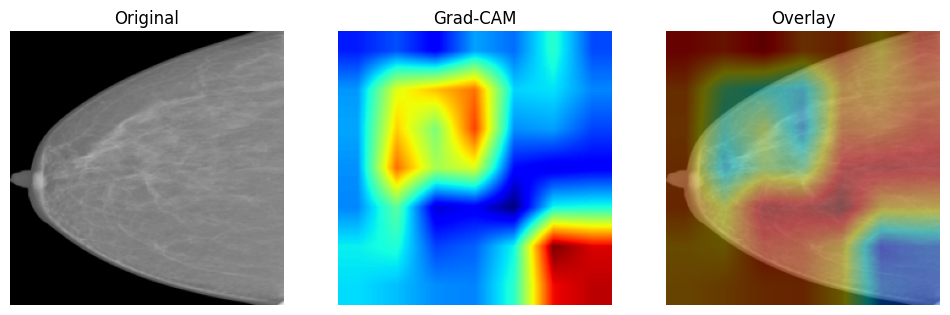

In [ ]:
#Grad-CAM Visualization
target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

sample = test_df.sample(1).iloc[0]
img = Image.open(sample["preprocessed_path"]).convert("RGB")
x = eval_tf(img).unsqueeze(0).to(device)

pred = model(x).argmax(1).item()
cam = gradcam.generate(x, pred)

img_np = np.array(img.resize((224,224)))
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
plt.show()


**Quantitative (neumerical analysis)**

In [ ]:

# Numerical Grad-CAM Quantification


# Mean activation intensity
cam_mean = cam.mean()

# Maximum activation intensity
cam_max = cam.max()

# Activation coverage (percentage of pixels above a threshold)
threshold = 0.5
cam_coverage = np.sum(cam > threshold) / cam.size

print(f"Grad-CAM mean_intensity: {cam_mean:.4f}")
print(f"Grad-CAM max_intensity: {cam_max:.4f}")
print(f"Grad-CAM coverage (> {threshold}): {cam_coverage:.4f}")

Grad-CAM mean_intensity: 0.3332
Grad-CAM max_intensity: 0.8554
Grad-CAM coverage (> 0.5): 0.2012
